# Identify Contrails with Keras

In [4]:
# reinstall tensorflow-io
# to avoid the UserWarning: unable to load libtensorflow_io_plugins.so

#!pip install tensorflow-io

---

In [5]:
import os

In [6]:
# ==============================

LOAD_CHECKPOINT = False  # <DEVEL>
TRAIN = True  # <DEVEL>

if os.path.exists('/kaggle'):
    PLATFORM = 'kaggle'
else:
    PLATFORM = 'gcp'

# ==============================

print(f'PLATFORM = {PLATFORM}')
print()
print(f'LOAD_CHECKPOINT = {LOAD_CHECKPOINT}')
print(f'TRAIN = {TRAIN}')

PLATFORM = kaggle

LOAD_CHECKPOINT = False
TRAIN = True


In [7]:
if PLATFORM == 'kaggle':

    WORK_DIR = '/kaggle/working'  # preserved if notebook is saved
    TEMP_DIR = '/kaggle/temp'  # just during current session

    DATA_DIR = '/kaggle/input/google-research-identify-contrails-reduce-global-warming'
    
    WEIGHTS_DIR = WORK_DIR
    
    resnet50_imagenet_weights =\
        '/kaggle/input/d/alexisbcook/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

    # You can write up to 20GB to the current directory (/kaggle/working/)
    # that gets preserved as output when you create a version using "Save & Run All" 
    # You can also write temporary files to /kaggle/temp/,
    # but they won't be saved outside of the current session

elif PLATFORM == 'gcp':

    WORK_DIR = '/home/jupyter/kaggle/working'  # preserved if notebook is saved
    TEMP_DIR = '/home/jupyter/kaggle/temp'  # just during current session

    DATA_DIR = '/home/jupyter/kaggle/input/google-research-identify-contrails-reduce-global-warming'
    
    WEIGHTS_DIR = '/home/jupyter/identify-contrails-models'
    
    resnet50_imagenet_weights = 'imagenet'
    
    %cd $WORK_DIR
    
else:
    raise NotImplementedError(f'unknown platform "{PLATFORM}"')

print('PWD =', os.getcwd())

PWD = /kaggle/working


In [8]:
UPDATE_DATA = False

if UPDATE_DATA:
    %cp -v /kaggle/input/identify-contrails/identify-contrails_2023*.h5 .
    %ll

In [9]:
if LOAD_CHECKPOINT:
    prev_checkpoint_path = os.path.join(WEIGHTS_DIR, 'identify-contrails_2023-07-22_16-22-01.h5')  # <DEVEL>
    print(f'prev_checkpoint_path = {prev_checkpoint_path}')
    if not os.path.exists(prev_checkpoint_path):
        raise IOError(f'file does not exist {prev_checkpoint_path}')

In [10]:
!touch submission.csv
%ll -h

total 3.1G
-rw-r--r-- 1 root  263 Jul 27 19:45 __notebook_source__.ipynb
-rw-r--r-- 1 root 109M Jul 27 19:45 contrails_2023-07-15_15-10-49.h5
-rw-r--r-- 1 root 109M Jul 27 19:45 contrails_2023-07-19_22-57-53.h5
-rw-r--r-- 1 root 137M Jul 27 19:45 contrails_2023-07-20_00-27-12.h5
-rw-r--r-- 1 root  73M Jul 27 19:45 contrails_2023-07-20_09-33-34.h5
-rw-r--r-- 1 root 109M Jul 27 19:45 contrails_2023-07-20_13-06-15.h5
-rw-r--r-- 1 root 137M Jul 27 19:45 contrails_2023-07-20_22-06-31.h5
-rw-r--r-- 1 root 137M Jul 27 19:45 contrails_2023-07-20_22-39-56.h5
-rw-r--r-- 1 root 137M Jul 27 19:45 contrails_2023-07-21_10-01-58.h5
-rw-r--r-- 1 root 109M Jul 27 19:45 contrails_2023-07-21_23-31-01.h5
-rw-r--r-- 1 root 109M Jul 27 19:45 contrails_2023-07-21_23-54-37.h5
-rw-r--r-- 1 root 137M Jul 27 19:45 contrails_2023-07-22_21-49-00.h5
-rw-r--r-- 1 root 137M Jul 27 19:45 contrails_2023-07-23_11-22-39.h5
-rw-r--r-- 1 root 137M Jul 27 19:45 contrails_2023-07-23_11-42-50.h5
-rw-r--r-- 1 root 137M Jul 27 

---

In [11]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import datetime
import itertools
import math
import multiprocessing
import pathlib
import random
import shutil

from pprint import pprint
from pytz import timezone
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy

In [12]:
PRINT_TIME_FORMAT = "%Y-%m-%d %H:%M:%S %Z%z"
FILE_TIME_FORMAT = "%Y-%m-%d_%H-%M-%S"

start_time = datetime.datetime.now(timezone('CET'))

file_time_str = start_time.strftime(FILE_TIME_FORMAT)

print('Started', start_time.strftime(PRINT_TIME_FORMAT))

Started 2023-07-27 22:15:27 CEST+0200


In [13]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as backend

AUTOTUNE = tf.data.AUTOTUNE

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [14]:
print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.12.0


In [15]:
print("Num CPUs Available: ", len(tf.config.list_physical_devices('CPU')))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print('cpu_count: ', multiprocessing.cpu_count())

Num CPUs Available:  1
Num GPUs Available:  0
cpu_count:  4


In [16]:
#---------------------------------------------------------------------------79

# Dataset utils

In [17]:
class Paths:
    train = os.path.join(DATA_DIR, 'train')
    valid = os.path.join(DATA_DIR, 'validation')
    test = os.path.join(DATA_DIR, 'test')

In [18]:
train_ids = sorted(os.listdir(Paths.train))
valid_ids = sorted(os.listdir(Paths.valid))
test_ids = sorted(os.listdir(Paths.test))
print('n_samples (train, validation, test) =', len(train_ids), len(valid_ids), len(test_ids))

n_samples (train, validation, test) = 20529 1856 2


In [19]:
class ABI:
    bands = {name: idx for idx, name in enumerate([
        '08', '09', '10', '11', '12', '13', '14', '15', '16'])}
    colors = {name: idx for idx, name in enumerate([
        'red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'yellow', 'black'])}

In [20]:
N_TIMES_BEFORE = 4
N_TIMES_AFTER = 3
N_TIMES = N_TIMES_BEFORE + N_TIMES_AFTER + 1

In [42]:
N_FRAMES = 5  # <DEVEL> centered around N_TIMES_BEFORE
N_FRAMES_BEFORE = int((N_FRAMES - 1) / 2)

In [43]:
def normalize_range(data, bounds):
    """Maps data to the range [0, 1]."""
    return (data - bounds[0]) / (bounds[1] - bounds[0])

_T11_BOUNDS = (243, 303)
_CLOUD_TOP_TDIFF_BOUNDS = (-4, 5)
_TDIFF_BOUNDS = (-4, 2)

def get_ash_colors(sample_id, split_dir):
    """
    Based on bands: 11, 14, 15
    
    Args:
        sample_id(str): The id of the example i.e. '1000216489776414077'
        split_dir(str): The split directoryu i.e. 'test', 'train', 'val'
    """
    band15 = np.load(DATA_DIR + f"/{split_dir}/{sample_id}/band_15.npy")
    band14 = np.load(DATA_DIR + f"/{split_dir}/{sample_id}/band_14.npy")
    band11 = np.load(DATA_DIR + f"/{split_dir}/{sample_id}/band_11.npy")

    r = normalize_range(band15 - band14, _TDIFF_BOUNDS)
    g = normalize_range(band14 - band11, _CLOUD_TOP_TDIFF_BOUNDS)
    b = normalize_range(band14, _T11_BOUNDS)
    ash_colors = np.clip(np.stack([r, g, b], axis=2), 0, 1)
    
    return ash_colors

In [44]:
def get_individual_mask(sample_id, split_dir):
    masks_path = DATA_DIR + f"/{split_dir}/{sample_id}/human_individual_masks.npy"
    pixel_mask = np.load(masks_path)
    return pixel_mask

def get_pixel_mask(sample_id, split_dir):
    masks_path = DATA_DIR + f"/{split_dir}/{sample_id}/human_pixel_masks.npy"
    pixel_mask = np.load(masks_path)
    return pixel_mask

**Check some values**

In [45]:
sample_id = 7829917977180135058  # train_ids[3]

print(f'Check `ash_colors` on one of the samples: {sample_id}')

ash_colors = get_ash_colors(sample_id, 'train')[..., N_TIMES_BEFORE]

print(ash_colors.shape)
for color in range(3):
    array = ash_colors[..., color]
    print(array.min(), array.max())

Check `ash_colors` on one of the samples: 7829917977180135058
(256, 256, 3)
0.0 0.50921124
0.097476535 0.86938816
0.031865694 0.81146187


In [46]:
pixel_mask = get_pixel_mask(sample_id, 'train')

print(pixel_mask.shape)
print(pixel_mask.min(), pixel_mask.max())

(256, 256, 1)
0 1


# Model

### Config

In [47]:
SEED = 42

In [48]:
class Config:  # <CONFIG>
    
    seed = SEED

    img_size = (256, 256)
    num_classes = 1
    
    augment = True
    
    model = 'p3dresnet'  # unet | deeplabv3plus | p3dresnet
    preprocess = None  # 'resnet50' | None
    backbone = 'resnet50'  # 'resnet50' | None
    backbone_weights = resnet50_imagenet_weights  # resnet50_imagenet_weights | 'imagenet' | None
    backbone_trainable = True
    dropout = False
    
    num_epochs = 2  # <DEVEL> else 10
    batch_size = 16  # <DEVEL> else 16 or 32
    steps_per_update = 1  # gradient accumulation
    
    initial_learning_rate = 0.001
    decay_steps = 5  # number of epochs
    decay_rate = 0.9

    threshold = 'auto'

In [49]:
# https://keras.io/examples/keras_recipes/reproducibility_recipes/

# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) `tensorflow` random seed
# 3) `python` random seed
keras.utils.set_random_seed(Config.seed)

# See also:
# tf.config.experimental.enable_op_determinism()

In [50]:
# Mixed Precision
# https://www.tensorflow.org/guide/mixed_precision#supported_hardware

if PLATFORM == 'kaggle':
    MIXED_PRECISION = True
elif PLATFORM == 'gcp':
    # No mixed precision on QCP:
    # "Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0.
    # Your GPU: Tesla P100-PCIE-16GB, compute capability 6.0"
    MIXED_PRECISION = False
else:
    raise NotImplementedError(f'unknown platform "{PLATFORM}"')

if MIXED_PRECISION:
    print('setting mixed_precision')

    NP_FLOAT = 'float16'
    TF_FLOAT = tf.float16
    TF_INT = tf.uint8
    
    keras.mixed_precision.set_global_policy('mixed_float16')
    final_dtype = 'float32'
    
else:
    print('no mixed_precision')

    NP_FLOAT = 'float32'
    TF_FLOAT = tf.float32
    TF_INT = tf.uint8

    final_dtype = None

setting mixed_precision


### U-Net

In [51]:
class UNet:
    '''U-Net model.
    
    Inspired by and adapted from:
    - https://keras.io/examples/vision/oxford_pets_image_segmentation
    - https://www.kaggle.com/code/shashwatraman/simple-unet-baseline-train-lb-0-580
    - https://www.coursera.org/learn/advanced-computer-vision-with-tensorflow/home/week/3
    '''
    
    def __init__(self, preprocess=None, backbone=None, weights='imagenet',
                 backbone_trainable=True, dropout=True):
        self.preprocess = preprocess
        self.backbone = backbone
        self.weights = weights
        self.backbone_trainable = backbone_trainable
        self.dropout = dropout
        
    def conv2d_block(self, input_tensor, n_filters, kernel_size=3):
        x = input_tensor
        for i in range(2):
            x = tf.keras.layers.SeparableConv2D(
                filters = n_filters, kernel_size=(kernel_size, kernel_size), padding='same')(x)
            #? kernel_initializer = 'he_normal'
            x = tf.keras.layers.BatchNormalization()(x)
            x = tf.keras.layers.Activation('relu')(x)
        return x

    def encoder_block(self, inputs, n_filters, pool_size, dropout):
        f = self.conv2d_block(inputs, n_filters=n_filters)
        p = tf.keras.layers.MaxPooling2D(pool_size)(f)
        p = tf.keras.layers.Dropout(dropout)(p)
        return f, p

    def basic_encoder(self, inputs, dropout=0.1):
        f1, p1 = self.encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=dropout)
        f2, p2 = self.encoder_block(p1, n_filters=128, pool_size=(2,2), dropout=dropout)
        f3, p3 = self.encoder_block(p2, n_filters=256, pool_size=(2,2), dropout=dropout)
        f4, p4 = self.encoder_block(p3, n_filters=512, pool_size=(2,2), dropout=dropout)
        return p4, (f1, f2, f3, f4)
    
    def effnet_encoder(self, inputs, dropout=0.1):
        
        effnetb3 = keras.applications.EfficientNetB3(
            weights=self.weights, include_top=False, input_tensor=inputs,
        )
        effnetb3.trainable = self.backbone_trainable
        print('backbone_trainable =', self.backbone_trainable)
        
        raise NotImplementedError('WIP')
        
        f1 = None  # effnetb3.get_layer("conv1_relu").output
        f2 = None  # effnetb3.get_layer("conv2_block3_out").output
        f3 = None  # effnetb3.get_layer("conv3_block4_out").output
        f4 = None  # effnetb3.get_layer("conv4_block5_out").output
        output = effnetb3.output
        
        return output, (f1, f2, f3, f4)
    
    def resnet_encoder(self, inputs, dropout=0.1):
        
        # The first Conv2D of the keras implementation of ResNet has strides=2:
        # x = layers.Conv2D(64, 7, strides=2, use_bias=use_bias, name="conv1_conv")(x)
        # i.e. the image is downsampled first.
        # To avoid this, we apply an upsample in front.
        upsample = keras.layers.UpSampling2D()(inputs) 

        resnet50 = keras.applications.ResNet50(
            weights=self.weights, include_top=False, input_tensor=upsample,
        )
        resnet50.trainable = self.backbone_trainable
        print('backbone_trainable =', self.backbone_trainable)
        
        f1 = resnet50.get_layer("conv1_relu").output
        f2 = resnet50.get_layer("conv2_block3_out").output
        f3 = resnet50.get_layer("conv3_block4_out").output
        f4 = resnet50.get_layer("conv4_block5_out").output
        output = resnet50.output
        
        return output, (f1, f2, f3, f4)
    
    def encoder(self, inputs, dropout=0.1):
        if self.backbone == 'resnet50':
            return self.resnet_encoder(inputs, dropout)
        elif self.backbone == 'effnetb3':
            return self.effnet_encoder(inputs, dropout)
        elif self.backbone is None:
            return self.basic_encoder(inputs, dropout)
        raise NotImplementedError(f'unknown backbone "{self.backbone}')

    def bottleneck(self, inputs):
        bottle_neck = self.conv2d_block(inputs, n_filters=1024)
        return bottle_neck

    def decoder_block(self, inputs, conv_output, n_filters, kernel_size, strides, dropout):
        u = tf.keras.layers.Conv2DTranspose(
            n_filters, kernel_size, strides=strides, padding = 'same')(inputs)
        u = tf.keras.layers.BatchNormalization()(u)
        c = tf.keras.layers.concatenate([u, conv_output])
        c = tf.keras.layers.Dropout(dropout)(c)
        c = self.conv2d_block(c, n_filters, kernel_size=3)
        return c

    def decoder(self, inputs, convs, num_classes, dropout=0.1):
        if self.backbone == 'resnet50':
            filters = [1024, 512, 256, 64]
        elif self.backbone is None:
            filters = [512, 256, 128, 64]
        else:
            raise NotImplementedError(f'unknown backbone "{self.backbone}')
        f1, f2, f3, f4 = convs
        c6 = self.decoder_block(inputs, f4, n_filters=filters[0], kernel_size=(3,3), strides=(2,2), dropout=dropout)
        c7 = self.decoder_block(c6, f3, n_filters=filters[1], kernel_size=(3,3), strides=(2,2), dropout=dropout)
        c8 = self.decoder_block(c7, f2, n_filters=filters[2], kernel_size=(3,3), strides=(2,2), dropout=dropout)
        c9 = self.decoder_block(c8, f1, n_filters=filters[3], kernel_size=(3,3), strides=(2,2), dropout=dropout)
        if num_classes == 1:
            activation = "sigmoid"
        else:
            activation = "softmax"
        outputs = layers.Conv2D(
            num_classes, kernel_size=3, activation=activation, padding="same", dtype=final_dtype)(c9)
        return outputs

    def model(self, image_size, num_classes):
        inputs = tf.keras.layers.Input(shape=(image_size,image_size,3))
        encoder_output, convs = self.encoder(inputs)
        for conv in convs:
            print(conv.name, conv.shape)
        bottle_neck = self.bottleneck(encoder_output)
        outputs = self.decoder(bottle_neck, convs, num_classes)
        model = tf.keras.Model(name=self.__class__.__name__, inputs=inputs, outputs=outputs)
        return model

### DeepLabV3+

In [52]:
class DeepLabV3Plus:
    '''DeepLabV3+ model.
    
    Adapted from:
    - https://keras.io/examples/vision/deeplabv3_plus/#inference-using-colormap-overlay
    
    Dropout from:
    - https://github.com/smspillaz/seg-reg
    '''
    
    def __init__(self, preprocess='resnet50', weights='imagenet', backbone_trainable=True,
                 dropout=False):
        self.preprocess = preprocess
        self.weights = weights
        self.backbone_trainable = backbone_trainable
        self.dropout = dropout
    
    def convolution_block(
        self,
        block_input,
        num_filters=256,
        kernel_size=3,
        dilation_rate=1,
        padding="same",
        use_bias=False,
    ):
        x = layers.Conv2D(
            num_filters,
            kernel_size=kernel_size,
            dilation_rate=dilation_rate,
            padding="same",
            use_bias=use_bias,
            kernel_initializer=keras.initializers.HeNormal(),
        )(block_input)
        x = layers.BatchNormalization()(x)
        return tf.nn.relu(x)

    def DilatedSpatialPyramidPooling(self, dspp_input):
        dims = dspp_input.shape
        x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
        
        x = self.convolution_block(x, kernel_size=1, use_bias=True)
        out_pool = layers.UpSampling2D(
            size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
        )(x)

        out_1 = self.convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
        out_6 = self.convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
        out_12 = self.convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
        out_18 = self.convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

        x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
        output = self.convolution_block(x, kernel_size=1)

        if self.dropout:
            output = tf.keras.layers.Dropout(0.1)(output)
        
        return output
    
    def model(self, image_size, num_classes):
        
        model_input = keras.Input(shape=(image_size, image_size, 3))
        
        resnet50 = keras.applications.ResNet50(
            weights=self.weights, include_top=False, input_tensor=model_input,
        )
        resnet50.trainable = self.backbone_trainable
        print('resnet50.trainable =', resnet50.trainable)
        
        x = resnet50.get_layer("conv4_block6_2_relu").output
        x = self.DilatedSpatialPyramidPooling(x)

        input_a = layers.UpSampling2D(
            size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
            interpolation="bilinear",
        )(x)
        input_b = resnet50.get_layer("conv2_block3_2_relu").output
        input_b = self.convolution_block(input_b, num_filters=48, kernel_size=1)

        x = layers.Concatenate(axis=-1)([input_a, input_b])
        x = self.convolution_block(x)
        if self.dropout:
            x = tf.keras.layers.Dropout(0.5)(x)
        x = self.convolution_block(x)
        if self.dropout:
            x = tf.keras.layers.Dropout(0.1)(x)
        x = layers.UpSampling2D(
            size=(image_size // x.shape[1], image_size // x.shape[2]),
            interpolation="bilinear",
        )(x)
        
        if num_classes == 1:
            activation = "sigmoid"
        else:
            activation = "softmax"
        model_output = layers.Conv2D(
            num_classes, kernel_size=(1, 1), activation=activation, padding="same", dtype=final_dtype)(x)
        
        return keras.Model(name=self.__class__.__name__, inputs=model_input, outputs=model_output)

In [70]:
class P3DResNet:
    '''Pseudo-3D Resnet model.
    
    Adapted from:
    - https://github.com/qijiezhao/pseudo-3d-pytorch/blob/master/p3d_model.py
    - https://github.com/yfxc/pseudo-3d-tensorflow/blob/master/P3D.py
    - https://github.com/keras-team/keras/blob/v2.13.1/keras/applications/resnet.py
    '''
    
    def __init__(self):
        
        self.blocks = [3, 4, 6, 3]  # P3D63 modelbased on a ResNet-50-3D model
        self.depth_3d=sum(self.layers[:3])
        
        self.maxpool_s = keras.layers.MaxPooling3D(pool_size=(3, 3, 1), strides=(2, 2, 1), padding='same')
        self.maxpool_t = keras.layers.MaxPooling3D(pool_size=(1, 1, 2), strides=(1, 1, 2), padding='same')
        #self.avgpool = keras.layers.GlobalAveragePooling2D()
    
    def block(x, filters, kernel_size=3, stride=1, conv_shortcut=True, name=None):
        """A residual block.

        Args:
          x: input tensor.
          filters: integer, filters of the bottleneck layer.
          kernel_size: default 3, kernel size of the bottleneck layer.
          stride: default 1, stride of the first layer.
          conv_shortcut: default True, use convolution shortcut if True,
              otherwise identity shortcut.
          name: string, block label.

        Returns:
          Output tensor for the residual block.
        """
        bn_axis = 3 if backend.image_data_format() == "channels_last" else 1

        if conv_shortcut:
            shortcut = layers.Conv2D(
                4 * filters, 1, strides=stride, name=name + "_0_conv"
            )(x)
            shortcut = layers.BatchNormalization(
                axis=bn_axis, epsilon=1.001e-5, name=name + "_0_bn"
            )(shortcut)
        else:
            shortcut = x

        x = layers.Conv2D(filters, 1, strides=stride, name=name + "_1_conv")(x)
        x = layers.BatchNormalization(
            axis=bn_axis, epsilon=1.001e-5, name=name + "_1_bn"
        )(x)
        x = layers.Activation("relu", name=name + "_1_relu")(x)

        x = layers.Conv2D(
            filters, kernel_size, padding="SAME", name=name + "_2_conv"
        )(x)
        x = layers.BatchNormalization(
            axis=bn_axis, epsilon=1.001e-5, name=name + "_2_bn"
        )(x)
        x = layers.Activation("relu", name=name + "_2_relu")(x)

        x = layers.Conv2D(4 * filters, 1, name=name + "_3_conv")(x)
        x = layers.BatchNormalization(
            axis=bn_axis, epsilon=1.001e-5, name=name + "_3_bn"
        )(x)

        x = layers.Add(name=name + "_add")([shortcut, x])
        x = layers.Activation("relu", name=name + "_out")(x)
        return x
    
    def stack(x, filters, blocks, stride, name=None):
        """A set of stacked residual blocks.

        Args:
          x: input tensor.
          filters: integer, filters of the bottleneck layer in a block.
          blocks: integer, blocks in the stacked blocks.
          stride1: default 2, stride of the first layer in the first block.
          name: string, stack label.

        Returns:
          Output tensor for the stacked blocks.
        """
        x = block1(x, filters, stride=stride1, name=name + "_block1")
        for i in range(2, blocks + 1):
            x = block1(
                x, filters, conv_shortcut=False, name=name + "_block" + str(i)
            )
        return x
    
    def model(self, image_size, num_classes):
        
        # (B, H, W, T, C) here
        # (B, C, T, H, W) in pseudo-3d-pytorch

        model_input = keras.Input(shape=(image_size, image_size, N_FRAMES, 3))
        
        x = keras.layers.Conv3D(
            64, kernel_size=(7, 7, 1), strides=(2, 2, 1), padding='same', use_bias=False
            )(model_input)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.ReLU()(x)
        x = self.maxpool_s(x)
        
        x = self.stack(x, 64, blocks[0], stride=1, shortcut_type, name="conv2")
        x = self.maxpool_t(x)
        x = self.stack(x, 128, blocks[1], stride=2, shortcut_type, name="conv3")
        x = self.maxpool_t(x)
        x = self.stack(x, 256, blocks[2], stride=2, shortcut_type, name="conv4")
        x = self.maxpool_t(x)
        x = self.stack(x, 512, blocks[3], stride=2, shortcut_type, name="conv5")
        #x = self.avgpool(x)
        
        model_output = x
        
        return keras.Model(name=self.__class__.__name__, inputs=model_input, outputs=model_output)

In [71]:
# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
if Config.model == 'unet':
    builder = UNet(
        preprocess=Config.preprocess,
        backbone=Config.backbone,
        weights=Config.backbone_weights,
        backbone_trainable=Config.backbone_trainable,
        dropout=Config.dropout
    )

elif Config.model == 'deeplabv3plus':
    builder = DeepLabV3Plus(
        preprocess=Config.preprocess,
        weights=Config.backbone_weights,
        backbone_trainable=Config.backbone_trainable,
        dropout=Config.dropout
    )

elif Config.model =='p3dresnet':
    builder = P3DResNet()

else:
    raise NotImplementedError(f'model "{Config.model}"')

model = builder.model(image_size=Config.img_size[0], num_classes=Config.num_classes)

model.summary()

Model: "P3DResNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 5, 3)]  0         
                                                                 
 conv3d (Conv3D)             (None, 128, 128, 5, 64)   9408      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 5, 64)  256       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 128, 128, 5, 64)   0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 64, 64, 5, 64)    0         
 )                                                               
                                                                 
Total params: 9,664
Trainable params: 9,536
Non-trainable

# Configure datasets (keras)

In [29]:
N_TRAIN = 1024  # 512 <DEVEL> else None (max 20529)
N_VALID = 256  # 128 <DEVEL> else None (max 1856)
N_PARTIAL = 128  # 128

In [30]:
print('preprocess =', builder.preprocess)

preprocess = None


### Multi-frame

In [32]:
class AshColorMultiFrames(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, sample_ids, split_dir, preprocess=None, n_samples=None):
        self.batch_size = batch_size
        self.img_size = img_size
        self.split_dir = split_dir
        self.sample_ids = sample_ids[:n_samples]
        self.preprocess = preprocess

    def __len__(self):
        return math.ceil(len(self.sample_ids) / self.batch_size)
    
    def get_sample_ids(self, idx):
        '''Get sample ids of batch idx.'''
        i = idx * self.batch_size
        return self.sample_ids[i : i + self.batch_size]
    
    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        
        batch_sample_ids = self.get_sample_ids(idx)
        
        sample_shape = self.img_size + (3,) + (N_FRAMES,)
        batch_shape = (self.batch_size,) + sample_shape
        x = np.zeros(batch_shape, dtype=NP_FLOAT)
        
        for j, sample_id in enumerate(batch_sample_ids):
            
            # img shape (H x W x 3 x T)
            img = get_ash_colors(sample_id, self.split_dir)

            prep_img = np.full(sample_shape, np.nan)
            for frame_idx in range(N_FRAMES):
                timestep_idx = N_TIMES_BEFORE - N_FRAMES_BEFORE + frame_idx
                if self.preprocess == 'resnet50':
                    img_t = keras.applications.resnet50.preprocess_input(img[..., timestep_idx])
                elif self.preprocess is None:
                    img_t = img[..., timestep_idx]
                else:
                    raise NotImplementedError(f'preprocess "{self.preprocess}"')
                prep_img[..., frame_idx] = img_t
            x[j] = prep_img

        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        if self.split_dir != 'test':
            for j, sample_id in enumerate(batch_sample_ids):
                # img shape (H x W x 1)
                img = get_pixel_mask(sample_id, self.split_dir)
                y[j] = img
        
        return x, y

In [33]:
train_set = AshColorMultiFrames(
    Config.batch_size, Config.img_size, train_ids, 'train',
    preprocess=builder.preprocess, n_samples=N_TRAIN)
print('number of batches:', len(train_set), 'train')

valid_set = AshColorMultiFrames(
    Config.batch_size, Config.img_size, valid_ids, 'validation',
    preprocess=builder.preprocess, n_samples=N_VALID)
print('number of batches:', len(valid_set), 'valid')

partial_set = AshColorMultiFrames(
    Config.batch_size, Config.img_size, valid_ids, 'validation',
    preprocess=builder.preprocess, n_samples=N_PARTIAL)
print('number of batches:', len(partial_set), 'partial')

test_set = AshColorMultiFrames(
    Config.batch_size, Config.img_size, test_ids, 'test',
    preprocess=builder.preprocess)
print('number of batches:', len(test_set), 'test')

number of batches: 64 train
number of batches: 16 valid
number of batches: 8 partial
number of batches: 1 test


In [34]:
print('Check dimensions (x, y) of first batch:')

train_set[0][0].shape, train_set[0][1].shape

Check dimensions (x, y) of first batch:


((16, 256, 256, 3, 5), (16, 256, 256, 1))

# Generate TFRecords

In [35]:
class TFDataSetCreator:
    '''Write TFRecords files and generate a TFRecordDataset from a keras.Sequence.
    
    Inspired by:
    - https://www.tensorflow.org/tutorials/load_data/tfrecord
    - https://keras.io/examples/keras_recipes/creating_tfrecords
    - https://keras.io/examples/keras_recipes/tfrecord
    - https://stackoverflow.com/questions/47861084/how-to-store-numpy-arrays-as-tfrecord
    
    References:
    - https://www.tensorflow.org/guide/data - Build TensorFlow input pipelines
    - https://www.tensorflow.org/guide/data_performance - Better performance with the tf.data API
    '''
    
    def __init__(self, keras_sequence, train, augment):
        self.keras_sequence = keras_sequence
        self.split_dir = keras_sequence.split_dir
        self.batch_size = keras_sequence.batch_size
        
        self.train = train
        self.augment = augment
        
        self.keep_existing = True
        self.records_dir = os.path.join(TEMP_DIR, f'records-multi{N_FRAMES}-{self.batch_size}-{self.split_dir}')
        self.record_paths = []
        
        self.progress_bar = True  # <DEVEL>
    
    def write_tfrec(self, batch_idx):
        #pid = multiprocessing.current_process().pid
        
        record_path = os.path.join(self.records_dir, f'batch_{batch_idx:04d}.tfrec')
        
        if self.keep_existing and os.path.exists(record_path):
            return record_path
        
        if self.progress_bar:
            if batch_idx % 100 == 0:
                print('o', end='')
            else:
                print('.', end='')

        x_b, y_b = self.keras_sequence[batch_idx]
        with tf.io.TFRecordWriter(record_path) as writer:
            for x, y in zip(x_b, y_b):
                feature = {
                    "x": tf.train.Feature(
                        bytes_list=tf.train.BytesList(value=[tf.io.serialize_tensor(x).numpy()])),
                    "y": tf.train.Feature(
                        bytes_list=tf.train.BytesList(value=[tf.io.serialize_tensor(y).numpy()])),
                }
                example = tf.train.Example(features=tf.train.Features(feature=feature))
                writer.write(example.SerializeToString())
        
        return record_path
    
    def generate_tfrec(self, keep_existing=True):
        
        self.keep_existing = keep_existing
        
        records_dir = self.records_dir
        os.makedirs(records_dir, exist_ok=True)
        
        n_records = len(self.keras_sequence)
        n_procs = multiprocessing.cpu_count() * 2
        print(f'generating {n_records} records with {n_procs} processes in: {records_dir}')
        %ll -hd $records_dir

        pool = multiprocessing.Pool(processes=n_procs)
        batch_indexes = range(n_records)
        record_paths = sorted(pool.map(self.write_tfrec, batch_indexes))
        if self.progress_bar:
            print()
        
        !du -sh $records_dir
        print()
        
        self.record_paths = record_paths
        return self
    
    @staticmethod
    def parse_tfrecord_sample(element):
        parse_dic = {
            'x': tf.io.FixedLenFeature([], tf.string),  # Note that it is tf.string, not tf.float32
            'y': tf.io.FixedLenFeature([], tf.string),  # Note that it is tf.string, not tf.float32
        }
        feature = tf.io.parse_single_example(element, parse_dic)
        feature['x'] = tf.io.parse_tensor(feature['x'], out_type=TF_FLOAT)
        feature['y'] = tf.io.parse_tensor(feature['y'], out_type=TF_INT)
        return feature

    @staticmethod
    def prepare_sample(features):
        '''Return (x,y) both as Tensors.'''
        # TODO: reshape tensor
        #return (tf.reshape(features['x'], Config.img_size + (3,)),
        #        tf.reshape(features['y'], Config.img_size + (1,)))
        return (features['x'][:, :, :, N_FRAMES_BEFORE],
                features['y'])

    def randomly_crop_resize_rotate(self, image, label=None):
        """Randomly scales image and label.
        
        - https://github.com/tensorflow/models/blob/.../research/deeplab/core/preprocess_utils.py
        - https://github.com/keras-team/keras/blob/v2.13.1/keras/layers/preprocessing/image_preprocessing.py
        
        Args:
        image: Image with shape [height, width, 3].
        label: Label with shape [height, width, 1].
        scale: The value to scale image and label. Random if None.

        Returns:
        Scaled image and label.
        """

        if not self.train:
            return image, label
        
        y1 = tf.random.uniform([1, 1], minval=0.0, maxval=0.2)
        x1 = tf.random.uniform([1, 1], minval=0.0, maxval=0.2)
        y2 = tf.random.uniform([1, 1], minval=0.8, maxval=1.0)
        x2 = tf.random.uniform([1, 1], minval=0.8, maxval=1.0)
        boxes = tf.concat([y1, x1, y2, x2], 1)
        
        rot90_k = tf.cast(tf.random.uniform([], minval=0., maxval=4.), tf.int32)

        def transform(img, method):
            img = tf.image.crop_and_resize(
                tf.expand_dims(img, 0),
                boxes, [0],
                [Config.img_size[0], Config.img_size[0]], 
                method=method
            )[0, ...]
            img = tf.image.rot90(img, rot90_k)
            return img
        
        image = tf.reshape(image, Config.img_size + (3,))
        image = transform(image, 'bilinear')

        if label is not None:
            label = tf.reshape(label, Config.img_size + (1,))
            label = transform(label, 'nearest')
        
        image = tf.cast(image, TF_FLOAT)
        label = tf.cast(label, TF_INT)
        
        return image, label

    def dataset(self, batch=True, shuffle=True):
        dataset = (
            tf.data.TFRecordDataset(self.record_paths, num_parallel_reads=AUTOTUNE)
            .map(self.parse_tfrecord_sample, num_parallel_calls=AUTOTUNE)
            .map(self.prepare_sample, num_parallel_calls=AUTOTUNE)
        )
        if shuffle:
            dataset = (
                dataset
                .shuffle(self.batch_size * 10)
            )
        if self.augment:
            dataset = (
                dataset
                .map(self.randomly_crop_resize_rotate, num_parallel_calls=AUTOTUNE)
            )
        if batch:
            dataset = (
                dataset
                .batch(self.batch_size)
            )
        dataset = (
            dataset
            .prefetch(AUTOTUNE)
        )
        return dataset

### Visualize data augmentation

In [36]:
def plot_samples(images, labels):
    
    if images[0].ndim != 3:
        raise IndexError(f'Not a single image, shape: {images[0].shape}')
    
    fig, axs = plt.subplots(2, len(images), figsize=(10, 4))

    for idx, (image, label) in enumerate(zip(images, labels)):
        axs[0, idx].imshow(image.astype('float32'))
        axs[1, idx].imshow(label.astype('int8'))

    plt.tight_layout() 
    plt.show()

    return

In [37]:
if False:  # <DEVEL>

    KEEP_EXISTING = False

    tf.debugging.set_log_device_placement(True)

    # Place tensors on the CPU
    with tf.device('/CPU:0'):

        tf_train_set = (
            TFDataSetCreator(train_set, train=True, augment=Config.augment)
            .generate_tfrec(KEEP_EXISTING)
            .dataset(batch=False, shuffle=False)
        )

    elements = []
    for _ in range(8):
        for idx, element in enumerate(tf_train_set.take(2)):
            if idx == 1:
                elements.append(element)
    plot_samples(
        [el[0].numpy() for el in elements],
        [el[1].numpy() for el in elements],
    )

### Write TFRecords

In [38]:
KEEP_EXISTING = True  # <DEVEL>

timeit_start = datetime.datetime.now()

#tf.config.run_functions_eagerly(False)
#tf.data.experimental.enable_debug_mode()

tf.debugging.set_log_device_placement(True)

# Place tensors on the CPU
with tf.device('/CPU:0'):

    tf_train_set = (
        TFDataSetCreator(train_set, train=True, augment=Config.augment)
        .generate_tfrec(KEEP_EXISTING)
        .dataset()
    )

    tf_valid_set = (
        TFDataSetCreator(valid_set, train=False, augment=Config.augment)
        .generate_tfrec(KEEP_EXISTING)
        .dataset()
    )

    tf_partial_set = (
        TFDataSetCreator(partial_set, train=False, augment=Config.augment)
        .generate_tfrec(KEEP_EXISTING)
        .dataset()
    )

    tf_test_set = (
        TFDataSetCreator(test_set, train=False, augment=Config.augment)
        .generate_tfrec(KEEP_EXISTING)
        .dataset()
    )

tf.debugging.set_log_device_placement(False)

timeit_end = datetime.datetime.now()
print('datasets generated in:', timeit_end - timeit_start)

generating 64 records with 4 processes in: /kaggle/temp/records-multi5-16-train
drwxr-xr-x 2 root 4.0K Jul 27 19:36 /kaggle/temp/records-multi5-16-train/
.o..............................................................
2.0G	/kaggle/temp/records-multi5-16-train

generating 16 records with 4 processes in: /kaggle/temp/records-multi5-16-validation
drwxr-xr-x 2 root 4.0K Jul 27 19:37 /kaggle/temp/records-multi5-16-validation/
..o.............
497M	/kaggle/temp/records-multi5-16-validation

generating 8 records with 4 processes in: /kaggle/temp/records-multi5-16-validation
drwxr-xr-x 2 root 4.0K Jul 27 19:37 /kaggle/temp/records-multi5-16-validation/

497M	/kaggle/temp/records-multi5-16-validation

generating 1 records with 4 processes in: /kaggle/temp/records-multi5-16-test
drwxr-xr-x 2 root 4.0K Jul 27 19:37 /kaggle/temp/records-multi5-16-test/
o
32M	/kaggle/temp/records-multi5-16-test

datasets generated in: 0:01:02.806893


# Training

In [39]:
def dice_coef(y_true, y_pred, smooth=0.001, threshold=None):
    '''Dice coefficient.
    
    Adapted from:
    - https://stackoverflow.com/questions/72195156/correct-implementation-of-dice-loss-in-tensorflow-keras
    - https://www.kaggle.com/code/shashwatraman/simple-unet-baseline-train-lb-0-580
    '''
    
    y_true_f = backend.flatten(tf.cast(y_true, TF_FLOAT))
    y_pred_f = backend.flatten(tf.cast(y_pred, TF_FLOAT))
    # ValueError: No gradients provided for any variable
    if threshold is not None:
        y_pred_f = backend.flatten(
            tf.cast(tf.math.greater(tf.cast(y_pred, TF_FLOAT), threshold), TF_FLOAT))
    intersection = backend.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (backend.sum(y_true_f) + backend.sum(y_pred_f) + smooth)
    return dice

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [40]:
#def threshold_dice_coef(y_true, y_pred, smooth=0.001):
#    '''Dice coefficient with threshold set to Config.threshold.'''
#    return dice_coef(y_true, y_pred, smooth=smooth, threshold=Config.threshold)

In [41]:
sample_id = 7829917977180135058  # train_ids[3]

print(f'Check dice_coef() on one of the samples: {sample_id}')

merged_mask = get_pixel_mask(sample_id, 'train')
indiv_masks = get_individual_mask(sample_id, 'train')

print(dice_coef(tf.convert_to_tensor(merged_mask),
                tf.convert_to_tensor(merged_mask)))
for idv in range(6):
    print(dice_coef(tf.convert_to_tensor(merged_mask),
                    tf.convert_to_tensor(indiv_masks[..., idv])))

Check dice_coef() on one of the samples: 7829917977180135058
tf.Tensor(1.0, shape=(), dtype=float16)
tf.Tensor(0.8745, shape=(), dtype=float16)
tf.Tensor(0.836, shape=(), dtype=float16)
tf.Tensor(0.739, shape=(), dtype=float16)
tf.Tensor(0.8525, shape=(), dtype=float16)
tf.Tensor(0.88, shape=(), dtype=float16)
tf.Tensor(0.8413, shape=(), dtype=float16)


### Gradient accumulation optimizer

In [42]:
class AccumAdam(keras.optimizers.Adam):
    """Adam optimizer with gradient accumulation over specified number of batches.
    
    References:
    - https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Optimizer
    """
    def __init__(self, steps_per_update=1, **kwargs):
        keras.optimizers.Adam.__init__(self, **kwargs)

        self.steps_per_update = steps_per_update
        self.step = 0
        self.accum_grads = {}
    
    def build(self, var_list):
        
        keras.optimizers.Adam.build(self, var_list)
        
        for var in var_list:
            var_key = var.name
            self.accum_grads[var_key] = tf.zeros(var.shape)
    
    def update_step(self, gradient, variable):

        step_mod = self.iterations % self.steps_per_update
        var_key = variable.name
        
        self.accum_grads[var_key] =\
            tf.case([(tf.equal(step_mod, 0), lambda: tf.zeros_like(gradient))],
                    default=lambda: self.accum_grads[var_key])
        
        self.accum_grads[var_key] += gradient
        
        accum_grad =\
            tf.case([(step_mod == self.steps_per_update - 1, lambda: self.accum_grads[var_key])],
                    default=lambda: tf.zeros_like(gradient))
    
        keras.optimizers.Adam.update_step(self, accum_grad, variable)

if Config.steps_per_update == 1:
    optimizer = keras.optimizers.Adam()
else:
    optimizer = AccumAdam(Config.steps_per_update)

In [43]:
checkpoint_path = f'identify-contrails_{file_time_str}.h5'
logger_path = f'identify-contrails_{file_time_str}_log.csv'

print(f'checkpoint file: {checkpoint_path}')

checkpoint file: identify-contrails_2023-07-27_21-36-05.h5


In [44]:
# Learning rate scheduler:
# - https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules
# - https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/CosineDecay
# Note: CosineDecay got warmup from v2.13.1 on

cos_scheduler = keras.optimizers.schedules.CosineDecay(
    Config.initial_learning_rate, Config.decay_steps)

exp_scheduler = keras.optimizers.schedules.ExponentialDecay(
    Config.initial_learning_rate, Config.decay_steps, Config.decay_rate)

In [45]:
# Configure the model for training.

# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
# See also:
# loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[dice_coef])

callbacks = [
    keras.callbacks.LearningRateScheduler(exp_scheduler),
    keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True),
    keras.callbacks.CSVLogger(logger_path, append=True)
]

### LET'S TRAIN!

In [52]:
if LOAD_CHECKPOINT:
    # Loads the weights
    model.load_weights(prev_checkpoint_path)
    print(f'model loaded weights from {prev_checkpoint_path}')

if TRAIN:
    # Train the model, doing validation at the end of each epoch.
    history = model.fit(
        tf_train_set, epochs=Config.num_epochs, validation_data=tf_valid_set, callbacks=callbacks,
        workers=4, use_multiprocessing=True)

Epoch 1/2
64/64 [==============================] - 19s 289ms/step - loss: 0.0279 - dice_coef: 0.0805 - val_loss: 0.0154 - val_dice_coef: 0.0025 - lr: 0.0010
Epoch 2/2
64/64 [==============================] - 19s 286ms/step - loss: 0.0238 - dice_coef: 0.1367 - val_loss: 0.0124 - val_dice_coef: 0.0017 - lr: 9.7915e-04


### History

History dict_keys(['loss', 'dice_coef', 'val_loss', 'val_dice_coef', 'lr'])


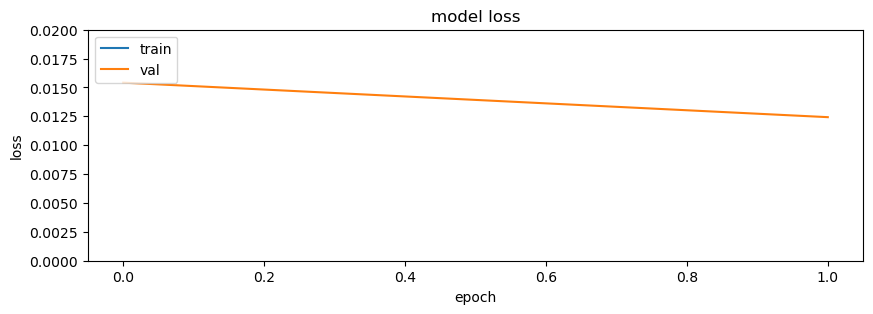

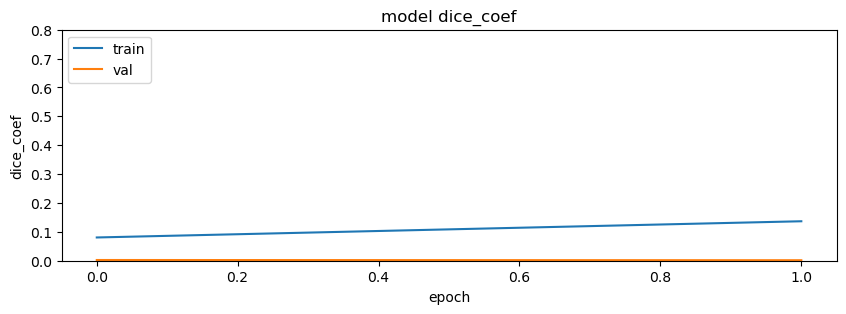

In [53]:
if TRAIN:
    print('History', history.history.keys())

    for var, yrange in [('loss', [0.0, 0.02]),
                        ('dice_coef', [0.0, 0.8])]:
        plt.figure(figsize=(10, 3))
        plt.plot(history.history[var])
        plt.plot(history.history[f'val_{var}'])
        plt.ylim(yrange[0], yrange[1])
        plt.title(f'model {var}')
        plt.xlabel('epoch')
        plt.ylabel(var)
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()

# Evaluate

In [54]:
def apply_threshold(pred, threshold):
    return (pred > threshold).astype(np.int8)

In [55]:
EVALUATE = True
ALL_BATCHES = True
BATCH_IDX = 0
SAMPLE_IDX = 11

In [56]:
if EVALUATE:    
    # Evaluate the model

    if ALL_BATCHES:
        loss, acc = model.evaluate(tf_partial_set, verbose=2)
    else:
        eval_images, eval_masks = tf_partial_set[BATCH_IDX]
        loss, acc = model.evaluate(eval_images, eval_masks, verbose=2)

    print("Model accuracy: {:5.2f}%".format(100 * acc))

8/8 - 1s - loss: 0.0146 - dice_coef: 0.0021 - 875ms/epoch - 109ms/step
Model accuracy:  0.21%


In [60]:
def eval_dice_coef(sample_set, pred_set, batch_size, threshold):
    dice_coef_per_batch = np.full(len(sample_set), np.nan)
    for idx in range(len(sample_set)):
        x, y = sample_set[idx]
        pred = pred_set[idx*batch_size:(idx + 1)*batch_size]
        _coef = dice_coef(y, pred, threshold=threshold)
        dice_coef_per_batch[idx] = _coef
    return dice_coef_per_batch

if EVALUATE:
    
    predictions = model.predict(partial_set)
    
    _coefs = eval_dice_coef(
        partial_set, predictions, batch_size=partial_set.batch_size, threshold=None)
    print(f'w/o threshold: {_coefs.mean():.2%}')
    
    if Config.threshold == 'auto':
        best_coef = 0.
        for threshold in np.arange(0.1, 0.8, 0.1):
            _coefs = eval_dice_coef(
                partial_set, predictions, batch_size=partial_set.batch_size, threshold=threshold)
            mean_coef = _coefs.mean()
            if mean_coef > best_coef:
                best_coef = mean_coef
                best_thresh = threshold
            print(f'{threshold:.02} threshold: {mean_coef:.2%}')
        print(f'best_threshold = {best_thresh:.02}')
        Config.threshold = best_thresh
        print('Config.threshold updated')
    else:
        threshold = Config.threshold
        _coefs = eval_dice_coef(
            partial_set, predictions, batch_size=partial_set.batch_size, threshold=threshold)
        mean_coef = _coefs.mean()
        print(f'{threshold:.02} threshold: {mean_coef:.2%}')

8/8 [==============================] - 1s 85ms/step


TypeError: '_PrefetchDataset' object is not subscriptable

In [ ]:
def plot_prediction(img, truth, pred):

    fig, axs = plt.subplots(1, 4, figsize=(16, 8))

    axs[0].imshow(img)
    axs[0].set_title("Ash Color Image")

    axs[1].imshow(truth)
    axs[1].set_title("Ground Truth")

    axs[2].imshow(pred)
    axs[2].set_title("Prediction")

    axs[3].imshow(img)
    axs[3].imshow(truth, cmap='Reds', alpha=.3, interpolation='none')
    axs[3].set_title('Contrail mask on ash color image')

    plt.tight_layout() 
    plt.show()

    return

if EVALUATE:
    eval_images, eval_masks = partial_set[BATCH_IDX]
    idx = SAMPLE_IDX
    threshold = Config.threshold
    plot_prediction(
        eval_images[idx], eval_masks[idx], apply_threshold(predictions[idx], threshold))

## Make predictions on test dataset

In [ ]:
predictions = model.predict(tf_test_set)

In [ ]:
len(predictions)

## Create a submission

In [ ]:
def rle_encode(x, fg_val=1):
    """
    Args:
        x:  numpy array of shape (height, width), 1 - mask, 0 - background
    Returns: run length encoding as list
    """

    dots = np.where(
        x.T.flatten() == fg_val)[0]  # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if b > prev + 1:
            run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths


def list_to_string(x):
    """
    Converts list to a string representation
    Empty list returns '-'
    """
    if x: # non-empty list
        s = str(x).replace("[", "").replace("]", "").replace(",", "")
    else:
        s = '-'
    return s


In [ ]:
test_recs = os.listdir(os.path.join(DATA_DIR, 'test'))

In [ ]:
submission = pd.read_csv(os.path.join(DATA_DIR, 'sample_submission.csv'), index_col='record_id')[0:0]

for test_id, pred in zip(test_ids, predictions):
    
    mask = apply_threshold(pred, Config.threshold)
    
    # notice the we're converting rec to an `int` here:
    submission.loc[int(test_id), 'encoded_pixels'] = list_to_string(rle_encode(mask))
    
submission.to_csv('submission.csv')

In [ ]:
def strf_timedelta(timedelta):
    total_seconds = timedelta.total_seconds()
    hours, remainder = divmod(total_seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    return '{:02}:{:02}:{:02}'.format(int(hours), int(minutes), int(seconds))

end_time = datetime.datetime.now(timezone('CET'))

print('Terminated', end_time.strftime(PRINT_TIME_FORMAT),
      'in', strf_timedelta(end_time - start_time))

---

THIS IS THE END!